In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
duration_df = pd.read_csv(f'raw-CSVs/Trace Analysis - durations.tsv', sep='\t')
duration_df

,mem_state,run,duration
0,Normal,1,39123.00088
1,Normal,2,39230.95389
2,Normal,3,39226.55989
3,Moderate,1,39186.83797
4,Moderate,2,39028.42234
5,Moderate,3,39388.73722


In [3]:
main_df = pd.DataFrame()
for mem_state in ['Normal', 'Moderate']:
    for run in [1, 2, 3]:
        to_append = pd.read_csv(f'raw-CSVs/Trace Analysis - {mem_state[0].lower()}_{run}.tsv', sep='\t')
        to_append['mem_state'] = mem_state
        to_append['run'] = run
        duration = duration_df.loc[duration_df['mem_state'] == mem_state].loc[duration_df['run'] == run]['duration'].iloc[0]
        to_append['duration'] = duration
        to_append['Percentage Time Spent (%)'] = (to_append['Wall duration (ms)']/duration)*100
        to_append['Time Spent (s)'] = to_append['Wall duration (ms)']/1000
        main_df = main_df.append(to_append, ignore_index=True)
# main_df

/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3593205654.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = main_df.append(to_append, ignore_index=True)
/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3593205654.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = main_df.append(to_append, ignore_index=True)
/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3593205654.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = main_df.append(to_append, ignore_index=True)
/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3593205654.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [4]:
df = main_df[['Process', 'State', 'Wall duration (ms)', 'Avg Wall duration (ms)', 'Occurrences', 'mem_state', 'run', 'Time Spent (s)']]
df['run'] = df['run'].astype(str)
df['mem_state_run'] = df['mem_state'] + ' Run #' + df['run']

def drop_from_df(df, label, label_name='State'):
    to_drop = df.loc[df[label_name] == label].index
    df = df.drop(index=to_drop)
    return df

for label in ['Task Dead', 'Parked', 'undefined (non-IO) + No Load + undefined + undefined + undefined + undefined', 'Sleeping', 'Uninterruptible Sleep + Wake Kill', 'Uninterruptible Sleep']:
    df = drop_from_df(df, label)
    
df = drop_from_df(df, 'kthreadd', label_name='Process')

df

df = df.groupby(['mem_state', 'run', 'State']).sum() #.to_frame(name = 'count').reset_index()
df.to_csv('temp')
df = pd.read_csv('temp')
df

df = df.groupby(['mem_state', 'State']).mean() #.to_frame(name = 'count').reset_index()
df.to_csv('temp')
df = pd.read_csv('temp')
df

/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3442050951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['run'] = df['run'].astype(str)
/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3442050951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mem_state_run'] = df['mem_state'] + ' Run #' + df['run']
/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3442050951.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is de

,mem_state,State,run,Wall duration (ms),Avg Wall duration (ms),Occurrences,Time Spent (s)
0,Moderate,Runnable,2.0,72350.770412,125.360968,184831.666667,72.350770
1,Moderate,Runnable (Preempted),2.0,26362.244680,108.669411,40375.666667,26.362245
2,Moderate,Running,2.0,63166.755262,52.202213,229675.000000,63.166755
3,Normal,Runnable,2.0,58248.509370,53.516336,224778.666667,58.248509
4,Normal,Runnable (Preempted),2.0,13330.198492,56.688536,26834.666667,13.330198
5,Normal,Running,2.0,69009.408754,42.946341,259491.333333,69.009409


In [5]:
os.remove('temp')

-5.842653492000004 14.102261041666672 13.032046188333338
-8.466459280686628 24.21050975228754 97.76333185496287


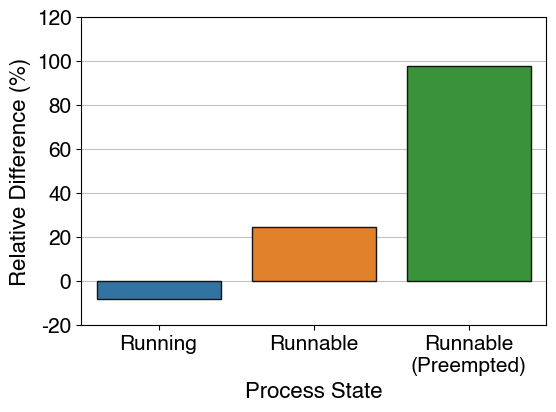

In [6]:
name = 'Time Spent (s)'

i = 0
runnable_inc = (( (runnable := df.loc[i, name] - df.loc[i+3, name])) / df.loc[i+3, name])*100
i = 1
runnable_preempted_inc = (((runnablep :=  df.loc[i, name] - df.loc[i+3, name])) / df.loc[i+3, name])*100
i = 2
running_inc = (((running :=  df.loc[i, name] - df.loc[i+3, name])) / df.loc[i+3, name])*100

print(running, runnable, runnablep)
print(running_inc, runnable_inc, runnable_preempted_inc)

fig, (ax) = plt.subplots(1, 1, figsize=(6, 4))

sns.barplot(ax=ax, x=['Running', 'Runnable', 'Runnable (Preempted)'], y=[running_inc, runnable_inc, runnable_preempted_inc],
           edgecolor='#141414', linewidth=1)

# ax.set_title("Sum of Time Spent in Process States for Threads of Firefox, MediaCodec and SurfaceFlinger")
ax.set_xlabel('Process State', fontsize=16)
ax.set_ylabel('Relative Difference (%)', fontsize=16)

ax.set_yticks(range(-20,120+10,20))
ax.set_yticklabels(range(-20,120+10,20), fontsize=15)
ax.set_xticklabels(['Running', 'Runnable', 'Runnable\n(Preempted)'], fontsize=15)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

plt.savefig(f"./systrace_1.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)

In [7]:
"""Plot kswapd stats"""

kswapd_df = main_df.loc[main_df['Thread'] == 'kswapd0']
kswapd_df['run'] = kswapd_df['run'].astype(str)
kswapd_df['mem_state_run'] = kswapd_df['mem_state'] + ' Run #' + kswapd_df['run']
# kswapd_df

def drop_from_df(df, label, label_name='State'):
    to_drop = df.loc[df[label_name] == label].index
    df = df.drop(index=to_drop)
    return df

# for label in ['Task Dead', 'Parked', 'undefined (non-IO) + No Load + undefined + undefined + undefined + undefined', 'Uninterruptible Sleep + Wake Kill', 'Uninterruptible Sleep']:
#     kswapd_df = drop_from_df(kswapd_df, label)

kswapd_df = drop_from_df(kswapd_df, 'Critical', label_name='mem_state')

kswapd_df.groupby(['Process', 'PID', 'Thread', 'TID', 'State', 'mem_state']).mean()

/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3714401686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kswapd_df['run'] = kswapd_df['run'].astype(str)
/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3714401686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kswapd_df['mem_state_run'] = kswapd_df['mem_state'] + ' Run #' + kswapd_df['run']
/var/folders/35/6xjjlvhn18q8lhz533ycffnr0000gp/T/ipykernel_21580/3714401686.py:18: FutureWarning: The default value of numeric

Wall duration (ms)  \
Process  PID Thread  TID State                 mem_state                       
kthreadd 2   kswapd0 85  Runnable              Moderate           114.295889   
                                               Normal             702.990428   
                         Runnable (Preempted)  Moderate          4959.122217   
                                               Normal            1598.056554   
                         Running               Moderate         21976.279787   
                                               Normal            2270.707807   
                         Sleeping              Moderate         12034.146330   
                                               Normal           29335.611913   
                         Uninterruptible Sleep Moderate            74.953109   
                                               Normal               5.534770   

                                                          Avg Wall duration (ms)  \
Process  PID Thread  TID State                 mem_state                           
kthreadd 2   kswapd0 85  Runnable              Moderate                 0.524193   
                                               Normal                   0.685363   
                         Runnable (Preempted)  Moderate                 0.602847   
                                               Normal                   0.855894   
                         Running               Moderate                 2.609101   
                                               Normal                   0.771439   
                         Sleeping              Moderate                73.577877   
                                               Normal                  39.405457   
                         Uninterruptible Sleep Moderate                 6.319376   
                                               Normal                   5.534770   

                                                          Occurrences  \
Process  PID Thread  TID State                 mem_state                
kthreadd 2   kswapd0 85  Runnable              Moderate    223.333333   
                                               Normal     1020.666667   
                         Runnable (Preempted)  Moderate   8220.666667   
                                               Normal     1873.333333   
                         Running               Moderate   8447.000000   
                                               Normal     2906.000000   
                         Sleeping              Moderate    167.000000   
                                               Normal      769.000000   
                         Uninterruptible Sleep Moderate     12.666667   
                                               Normal        1.000000   

                                                              duration  \
Process  PID Thread  TID State                 mem_state                 
kthreadd 2   kswapd0 85  Runnable              Moderate   39201.332510   
                                               Normal     39193.504887   
                         Runnable (Preempted)  Moderate   39201.332510   
                                               Normal     39193.504887   
                         Running               Moderate   39201.332510   
                                               Normal     39193.504887   
                         Sleeping              Moderate   39201.332510   
                                               Normal     39193.504887   
                         Uninterruptible Sleep Moderate   39201.332510   
                                               Normal     39123.000880   

                                                          Percentage Time Spent (%)  \
Process  PID Thread  TID State                 mem_state                              
kthreadd 2   kswapd0 85  Runnable              Moderate                    0.291734   
                                               Normal        

In [8]:
subtitlefs = 16
xylabelfs = 16
xyticksfs = 15
legendfs = 14

fig_height = 3

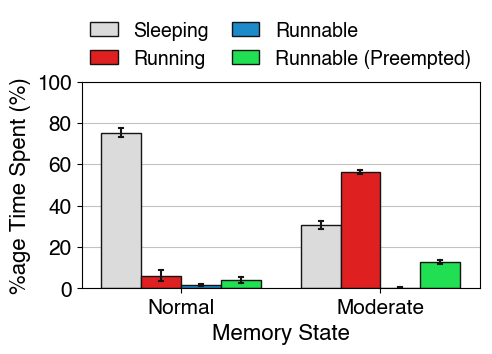

In [9]:
fig, ax2 = plt.subplots(1, 1, figsize=(5,fig_height))

ax = ax2

sns.barplot(ax=ax, data=kswapd_df, x='mem_state', y='Percentage Time Spent (%)', hue='State',
            hue_order=['Sleeping', 'Running', 'Runnable', 'Runnable (Preempted)'],
            palette={'Sleeping': '#DBDBDB', 'Running': 'red', 'Runnable': '#0092E6', 'Runnable (Preempted)': '#00FF43'},
           edgecolor='#141414', linewidth=1,
           capsize=.02, errwidth=1.5, errcolor='#141414')

ax.set_title("")
ax.set_xlabel('Memory State', fontsize=xylabelfs)
ax.set_ylabel('%age Time Spent (%)', fontsize=xylabelfs)

ax.set_yticks(range(0,100+10,20))
ax.set_yticklabels(range(0,100+10,20), fontsize=xyticksfs)
ax.set_xticklabels(['Normal', 'Moderate'], fontsize=xyticksfs)

ax.set_axisbelow(True)
ax.yaxis.grid(color='#C2C2C2')

plt.tight_layout()
ax.legend(bbox_to_anchor=(0.5, 1.18), loc='center', fontsize=legendfs, borderaxespad=0., borderpad=0.6, ncol=2, frameon=False,\
    labelspacing=0.45,handlelength=1.4,columnspacing=1.2)

# ax.legend(loc='center', bbox_to_anchor=(0.5, 1.125), \
#            fontsize=legendfs, borderaxespad=0., borderpad=0.2, ncol=5, frameon=False,\
#          handletextpad=0.5, labelspacing=2, handlelength=1.75, columnspacing=1.5)

plt.savefig(f"./systrace_final.jpg", format="jpg" , dpi=200, bbox_inches='tight', pad_inches=0.05)